In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind
import numpy as np

In [ ]:
ruta_estudiantes = r"/content/drive/MyDrive/Colab Notebooks/peru_student_enrollment_data_2023.csv"
df_estudiantes = pd.read_csv(ruta_estudiantes, sep = ";")

# Lectura de datos


### Contexto:

Las universidades enfrentan el desafío constante de identificar a estudiantes en riesgo de bajo rendimiento académico, con el fin de intervenir a tiempo mediante tutorías, apoyo psicológico o estrategias pedagógicas.

Este proyecto se basa en un dataset real sobre 37,582 estudiantes de educación superior peruana matriculados en 2023. Se busca utilizar modelos de deep learning, en particular TabNet, para predecir qué estudiantes podrían tener al menos un curso en riesgo de desaprobar.

### Variables:

| Variable                          | Descripción                                                                 |
|----------------------------------|-----------------------------------------------------------------------------|
| ENROLLMENT                       | Tipo de matrícula: Nueva, Reincorporado, Reingresado, etc.                 |
| TUITION PAYMENT MARCH 2022       | 1 si pagó matrícula en marzo 2022, 0 si no.                                 |
| TUITION PAYMENT MARCH 2023       | 1 si pagó matrícula en marzo 2023, 0 si no. *(posible target alternativo)* |
| GENDER                           | Género del estudiante (M, F, U, 1, 2 – requiere limpieza).                  |
| TYPE OF EDUCATIONAL INSTITUTION  | Tipo de institución de procedencia (Escuela, Instituto, etc.).             |
| EDUCATIONAL INSTITUTION          | Nombre de la institución de procedencia.                                   |
| INSTITUTION STATUS               | Pública o privada.                                                         |
| DEPARTMENT, PROVINCE, DISTRICT   | Ubicación geográfica de residencia o estudio.                              |
| CLASSIFICATION                   | Tipo de estudiante (probablemente interna).                                |
| CAMPUS                           | Sede donde estudia el alumno.                                              |
| FACULTY                          | Facultad a la que pertenece.                                               |
| PROGRAM/MAJOR                    | Carrera o programa de estudio.                                             |
| SHIFT/SCHEDULE                   | Horario de estudio: Mañana, Tarde, Noche, Mixto.                           |
| BENEFIT DISCOUNTS                | Si tiene algún descuento o beneficio económico.                            |
| STUDY MODE                       | Modalidad: Presencial, Online, Remoto, Indefinido.                         |
| AGE RANGE OF ENROLLED STUDENT    | Rango etario del estudiante.                                               |
| DISABILITY                       | Si tiene discapacidad (sí/no u otros).                                     |
| NUMBER OF ENROLLED COURSES       | Número de cursos matriculados.                                             |
| AT-RISK COURSE                   | 1 si tiene algún curso en riesgo de desaprobar, 0 si no. *(target propuesto)* |


## ¿Por qué usar TabNet?

- TabNet es un modelo profundo especialmente diseñado para datos tabulares, que combina la potencia de las redes neuronales con una estructura que aprende automáticamente qué variables priorizar para cada muestra.

- No necesita transformar excesivamente las variables categóricas como XGBoost (puede trabajar con índices directamente).

- Ofrece interpretabilidad fila por fila (qué variables activaron la predicción de riesgo en un estudiante específico).

- Es eficiente para estructuras grandes con muchas columnas, y detecta relaciones no lineales complejas.



In [ ]:
pd.options.display.max_columns = None
df_estudiantes.head()

,ENROLLMENT,TUITION PAYMENT MARCH 2022,TUITION PAYMENT MARCH 2023,GENDER,TYPE OF EDUCATIONAL INSTITUTION,EDUCATIONAL INSTITUTION,INSTITUTION STATUS,DEPARTMENT,PROVINCE,DISTRICT,CLASSIFICATION,CAMPUS,FACULTY,PROGRAM/MAJOR,SHIFT/SCHEDULE,BENEFIT DISCOUNTS,STUDY MODE,AGE RANGE OF ENROLLED STUDENT,DISABILITY,NUMBER OF ENROLLED COURSES,AT-RISK COURSE
0,Nuevo,0,0,M,INSTITUTO,IDAT,PRIVADA,LIMA,LIMA,BRENA,Carreras Pregrado,UTP Lima Centro,Fac. Ing. Sist. Y Elect.,ING. DE REDES Y COMUNICACIONES,MIXTO,SIN BENEFICIO,Presencial,5. >=30,No,0,0
1,Nuevo,1,0,M,COLEGIO,COLEGIO SISE,PRIVADA,LIMA,LIMA,VILLA MARIA DEL TRIUNFO,Carreras Pregrado,UTP Lima Centro,Fac. Ing. Sist. Y Elect.,ING. DE SISTEMAS,NOCHE,SIN BENEFICIO,Presencial,4. 24-29,No,3,0
2,Nuevo,1,1,F,NaN,NaN,NaN,LIMA,LIMA,JESUS MARIA,Carreras Pregrado,UTP Lima Centro,Fac. Der. Cienc. Polit. Y RRII,DERECHO,NOCHE,SIN BENEFICIO,Presencial,4. 24-29,No,1,0
3,Nuevo,0,0,F,COLEGIO,1220 SAN JOSE MARELLO,ESTATAL,LIMA,LIMA,ATE,Carreras Pregrado 50-50,UTP Lima Centro,Fac. Adm. Y Neg.,ADMINISTRACION DE NEGOCIOS (50/50),NOCHE,SIN BENEFICIO,Presencial,4. 24-29,No,0,0
4,Nuevo,1,1,F,INSTITUTO,IDAT,PRIVADA,LIMA,LIMA,SURQUILLO,Carreras Pregrado,UTP Lima Centro,Fac. Adm. Y Neg.,ADM. DE NEGOCIOS INTERNACIO,MAÑANA,CONVENIOS,Presencial,4. 24-29,No,2,0


# Ruta de análisis exploratorio (EDA)

### Paso 1: Limpieza inicial

In [ ]:
df_estudiantes.apply(lambda col: pd.Series({
    "NaNs": col.isnull().sum(),
    "Categorías": col.nunique() if col.dtype == 'object' else "-"
})).T.sort_values("NaNs", ascending=False)

,NaNs,Categorías
TYPE OF EDUCATIONAL INSTITUTION,21714,3
INSTITUTION STATUS,21714,2
EDUCATIONAL INSTITUTION,19370,4122
DEPARTMENT,736,25
PROVINCE,736,165
DISTRICT,736,694
SHIFT/SCHEDULE,58,4
AGE RANGE OF ENROLLED STUDENT,4,5
GENDER,2,5
CLASSIFICATION,1,5


Variables como TYPE OF EDUCATIONAL INSTITUTION, INSTITUTION STATUS	, EDUCATIONAL INSTITUTION serán eliminadas pues mas del 50% de los registros es nulo.

In [ ]:
# Renombrar columnas al español
column_mapping = {
    "ENROLLMENT": "tipo_matricula",
    "TUITION PAYMENT MARCH 2022": "pago_marzo_2022",
    "TUITION PAYMENT MARCH 2023": "pago_marzo_2023",
    "GENDER": "genero",
    "TYPE OF EDUCATIONAL INSTITUTION": "tipo_institucion_procedencia",
    "EDUCATIONAL INSTITUTION": "institucion_procedencia",
    "INSTITUTION STATUS": "condicion_institucion",
    "DEPARTMENT": "departamento",
    "PROVINCE": "provincia",
    "DISTRICT": "distrito",
    "CLASSIFICATION": "clasificacion",
    "CAMPUS": "campus",
    "FACULTY": "facultad",
    "PROGRAM/MAJOR": "programa",
    "SHIFT/SCHEDULE": "turno",
    "BENEFIT DISCOUNTS": "beneficios",
    "STUDY MODE": "modalidad",
    "AGE RANGE OF ENROLLED STUDENT": "rango_edad",
    "DISABILITY": "discapacidad",
    "NUMBER OF ENROLLED COURSES": "num_cursos",
    "AT-RISK COURSE": "riesgo_academico"
}

# Aplicar renombramiento
df_estudiantes.rename(columns=column_mapping, inplace=True)

# Asegurar que la columna de riesgo sea binaria (0 o 1)
df_estudiantes["riesgo_academico"] = df_estudiantes["riesgo_academico"].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
# Eliminamos las columnas con muchos valores nulos
df_estudiantes = df_estudiantes.drop(["tipo_institucion_procedencia", "institucion_procedencia","condicion_institucion"], axis=1)

# Eliminamos los registros sin georreferencia
df_estudiantes = df_estudiantes.query("~distrito.isna()")

In [ ]:
df_estudiantes.apply(lambda col: pd.Series({
    "NaNs": col.isnull().sum(),
    "Categorías": col.nunique() if col.dtype == 'object' else "-"
})).T.sort_values("NaNs", ascending=False)

,NaNs,Categorías
turno,55,4
rango_edad,4,5
genero,2,5
facultad,1,8
programa,1,85
clasificacion,1,5
num_cursos,0,-
discapacidad,0,2
modalidad,0,4
beneficios,0,7


In [ ]:
## Disminuir las categorias de genero

df_estudiantes["genero"] = df_estudiantes['genero'].map({
    'M': 'Masculino',
    'F': 'Femenino',
    'U': 'Desconocido',
    1: 'Masculino',
    2: 'Femenino'
})

Análisis bivariado para variables categóricas:
🔹 TIPO_MATRICULA → p-valor chi² = 0.0000 (significativo)


/tmp/ipython-input-10-1929876188.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=riesgo_mean.values, y=riesgo_mean.index, palette='coolwarm')


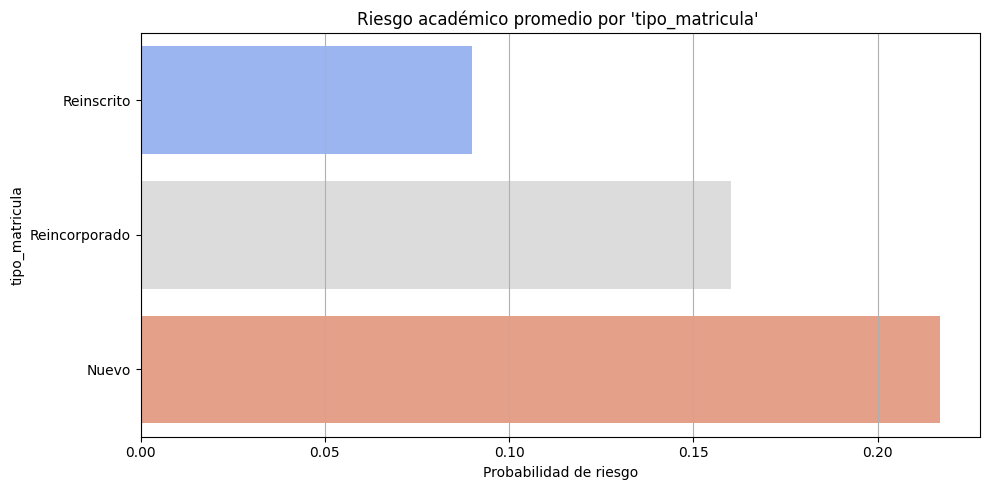

🔹 GENERO → p-valor chi² = 0.0000 (significativo)


/tmp/ipython-input-10-1929876188.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=riesgo_mean.values, y=riesgo_mean.index, palette='coolwarm')


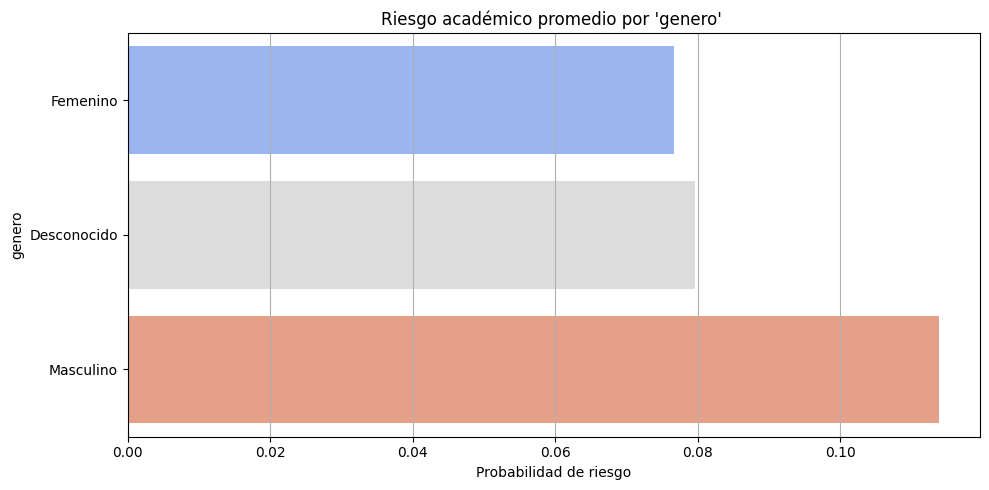

🔹 DEPARTAMENTO → p-valor chi² = 0.0000 (significativo)


/tmp/ipython-input-10-1929876188.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=riesgo_mean.values, y=riesgo_mean.index, palette='coolwarm')


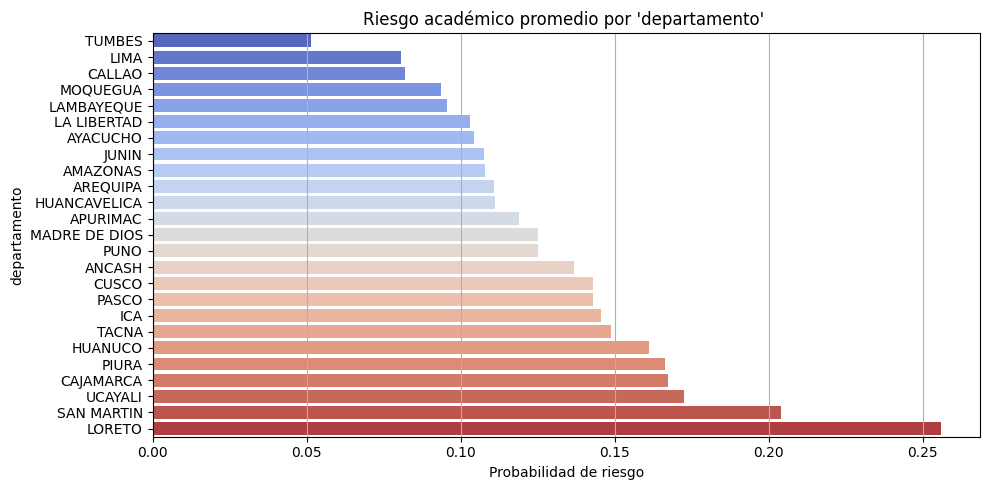

🔹 PROVINCIA → p-valor chi² = 0.0000 (significativo)


/tmp/ipython-input-10-1929876188.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=riesgo_mean.values, y=riesgo_mean.index, palette='coolwarm')


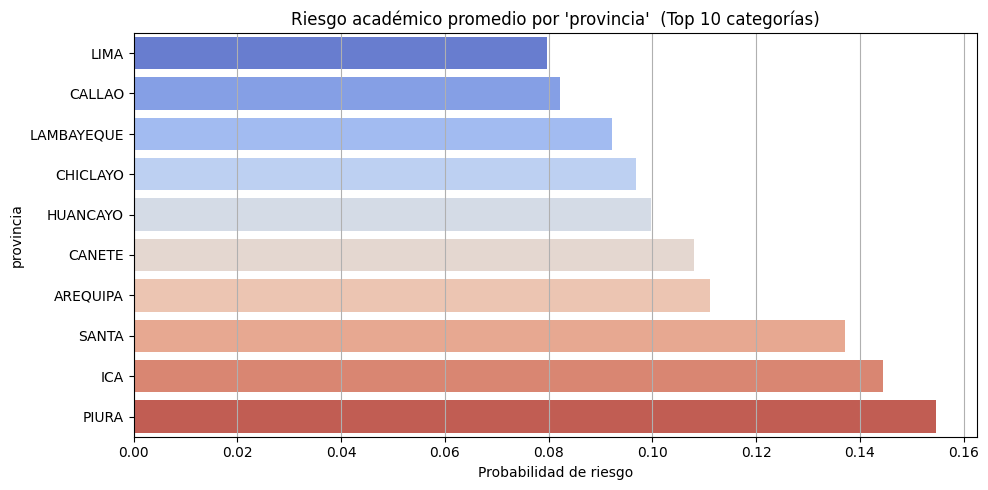

🔹 DISTRITO → p-valor chi² = 0.1883 (no significativo)


/tmp/ipython-input-10-1929876188.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=riesgo_mean.values, y=riesgo_mean.index, palette='coolwarm')


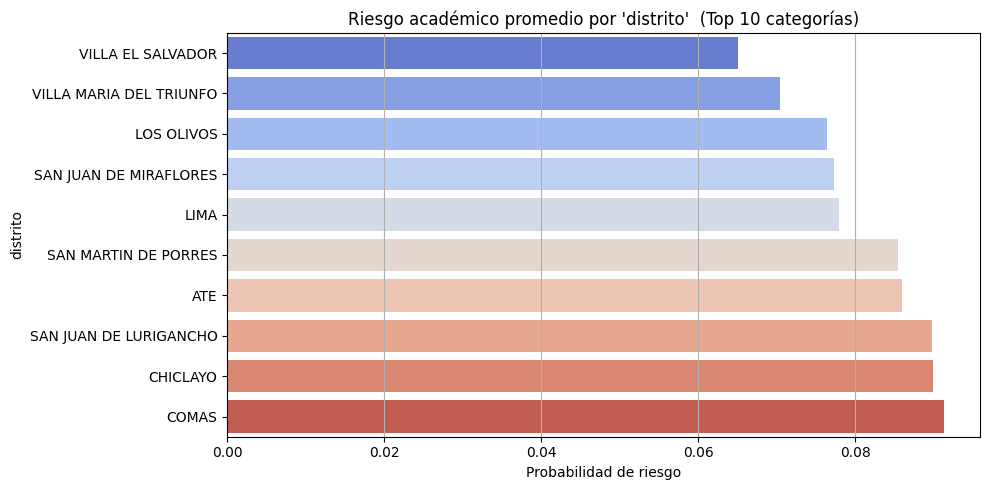

🔹 CLASIFICACION → p-valor chi² = 0.0000 (significativo)


/tmp/ipython-input-10-1929876188.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=riesgo_mean.values, y=riesgo_mean.index, palette='coolwarm')


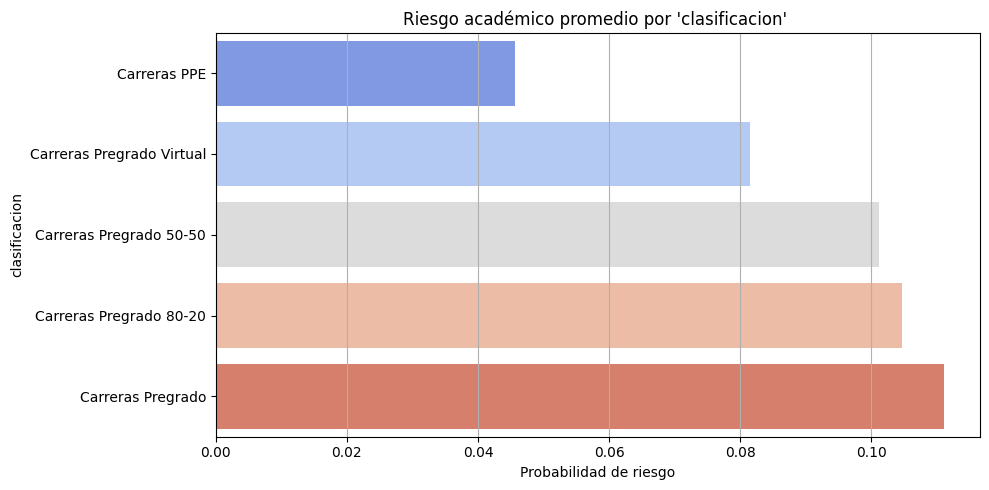

🔹 CAMPUS → p-valor chi² = 0.0000 (significativo)


/tmp/ipython-input-10-1929876188.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=riesgo_mean.values, y=riesgo_mean.index, palette='coolwarm')


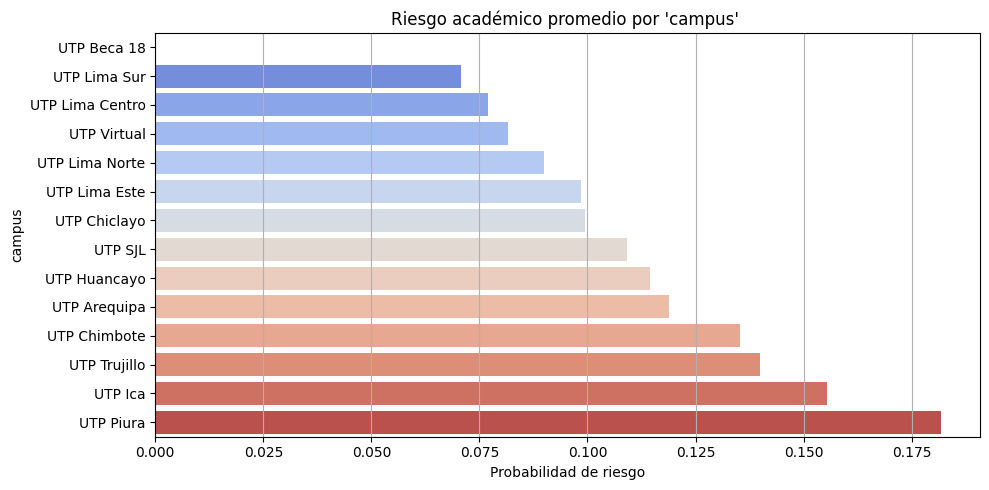

🔹 FACULTAD → p-valor chi² = 0.0000 (significativo)


/tmp/ipython-input-10-1929876188.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=riesgo_mean.values, y=riesgo_mean.index, palette='coolwarm')


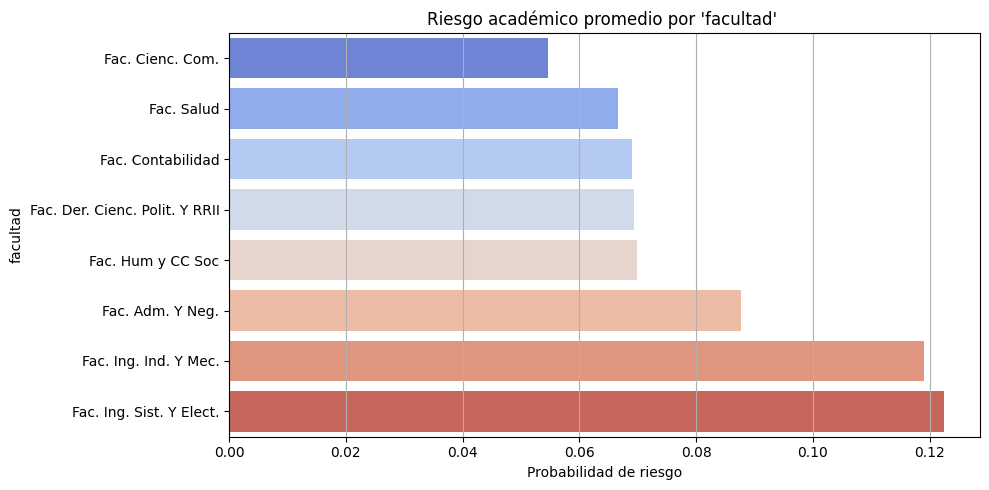

🔹 PROGRAMA → p-valor chi² = 0.0000 (significativo)


/tmp/ipython-input-10-1929876188.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=riesgo_mean.values, y=riesgo_mean.index, palette='coolwarm')


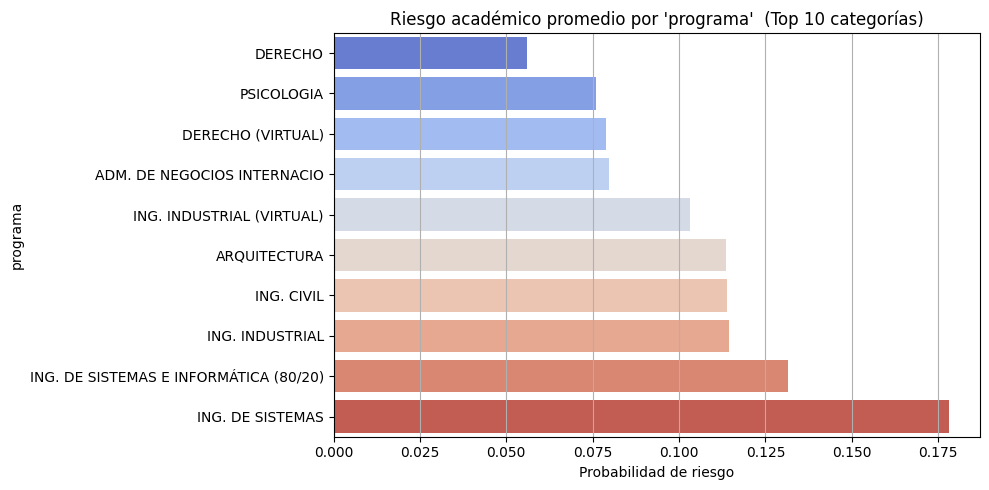

🔹 TURNO → p-valor chi² = 0.0000 (significativo)


/tmp/ipython-input-10-1929876188.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=riesgo_mean.values, y=riesgo_mean.index, palette='coolwarm')


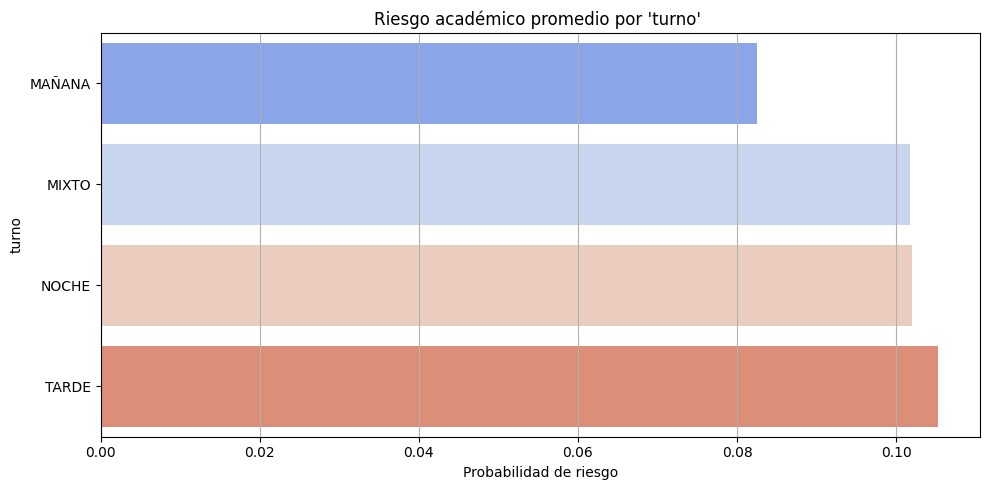

🔹 BENEFICIOS → p-valor chi² = 0.0000 (significativo)


/tmp/ipython-input-10-1929876188.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=riesgo_mean.values, y=riesgo_mean.index, palette='coolwarm')


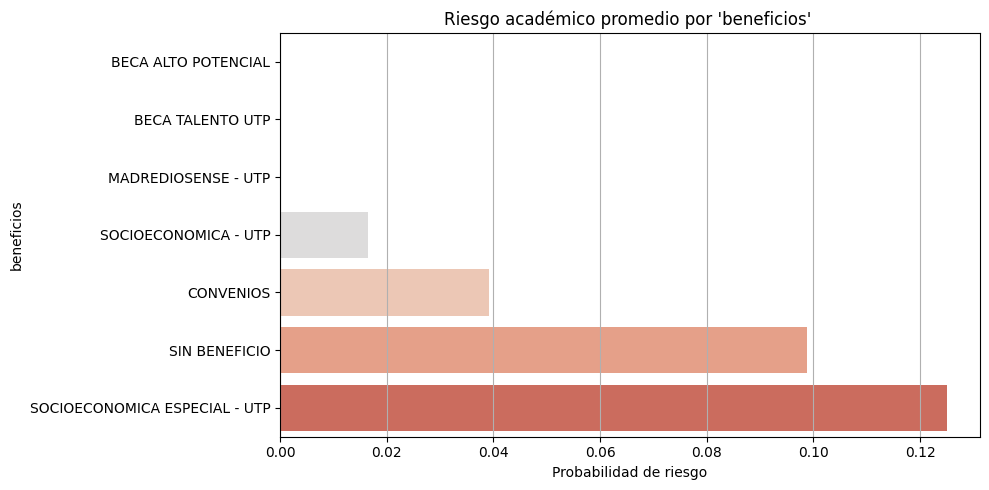

🔹 MODALIDAD → p-valor chi² = 0.0000 (significativo)


/tmp/ipython-input-10-1929876188.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=riesgo_mean.values, y=riesgo_mean.index, palette='coolwarm')


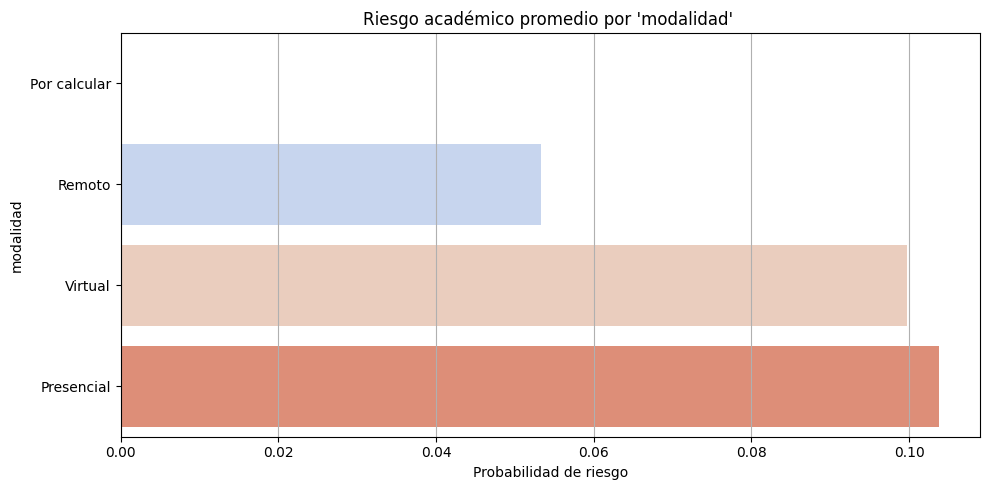

🔹 RANGO_EDAD → p-valor chi² = 0.0000 (significativo)


/tmp/ipython-input-10-1929876188.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=riesgo_mean.values, y=riesgo_mean.index, palette='coolwarm')


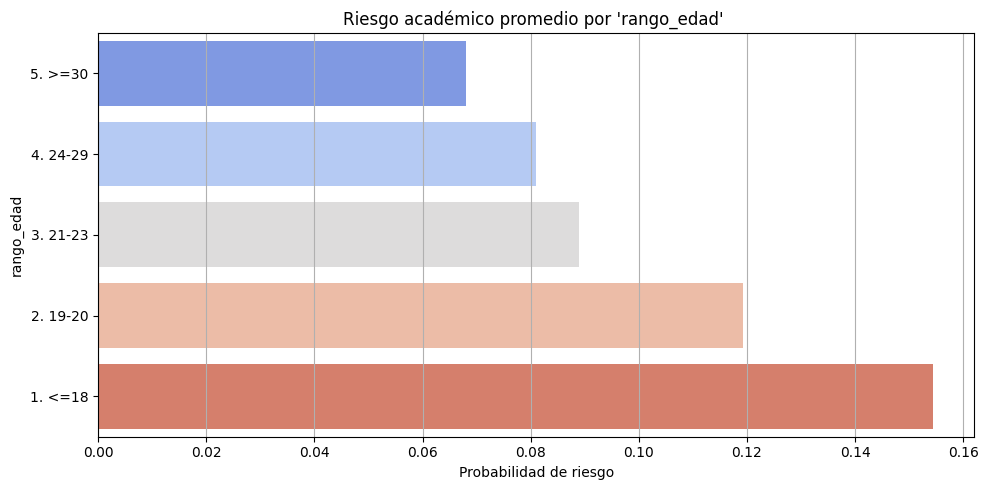

/tmp/ipython-input-10-1929876188.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=riesgo_mean.values, y=riesgo_mean.index, palette='coolwarm')


🔹 DISCAPACIDAD → p-valor chi² = 0.8047 (no significativo)


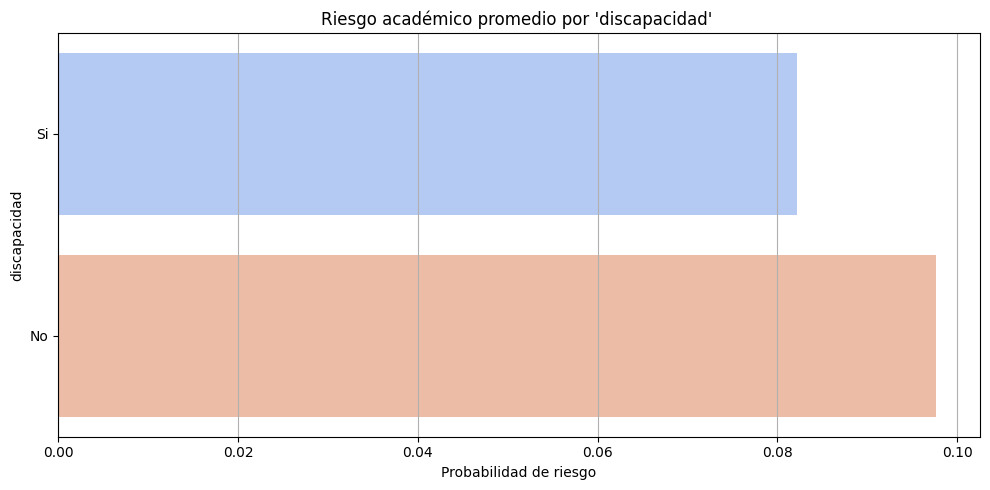

Análisis bivariado para variables numéricas:
🔹 PAGO_MARZO_2022 → p-valor t-test = 0.0000 (diferencia significativa)


/tmp/ipython-input-10-1929876188.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="riesgo_academico", y=col, palette="Set2")


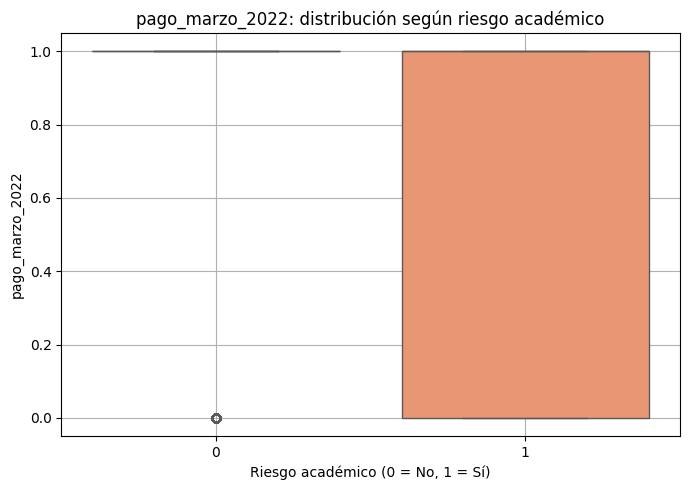

🔹 PAGO_MARZO_2023 → p-valor t-test = 0.0000 (diferencia significativa)


/tmp/ipython-input-10-1929876188.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="riesgo_academico", y=col, palette="Set2")


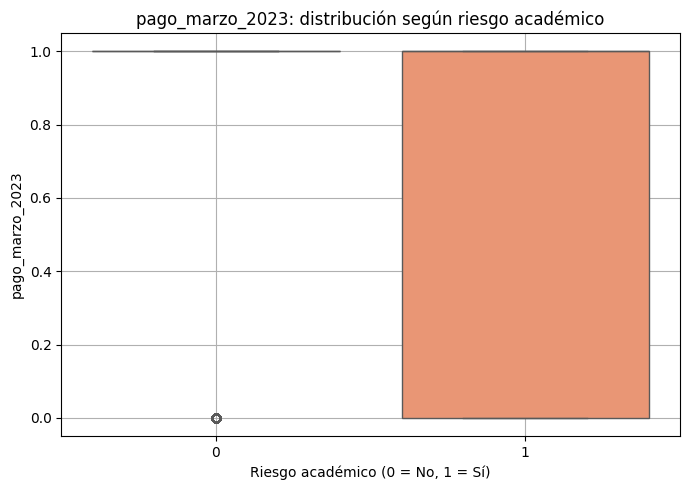

🔹 NUM_CURSOS → p-valor t-test = 0.0000 (diferencia significativa)


/tmp/ipython-input-10-1929876188.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="riesgo_academico", y=col, palette="Set2")


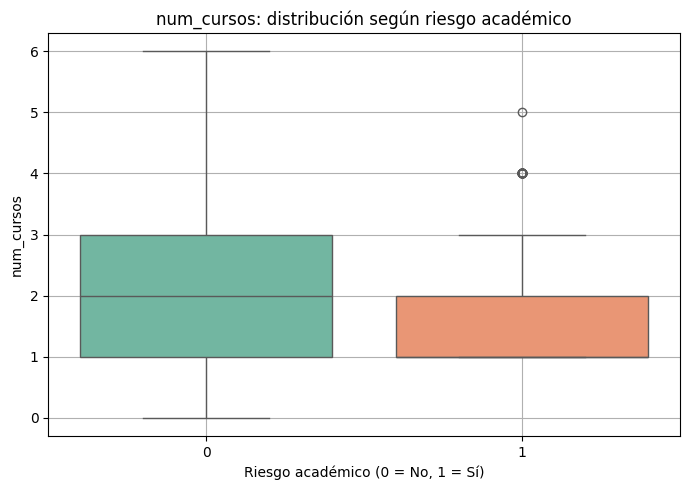

In [ ]:
df = df_estudiantes.copy()

# Separar variables
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
num_cols = [col for col in df.columns if df[col].dtype != 'object' and col != 'riesgo_academico']

# ---------- CATEGÓRICAS ----------
print("Análisis bivariado para variables categóricas:")

for col in cat_cols:
    if df[col].nunique() > 30:
        top_cats = df[col].value_counts().head(10).index
        temp = df[df[col].isin(top_cats)]
        title_suffix = " (Top 10 categorías)"
    else:
        temp = df.copy()
        title_suffix = ""

    # Riesgo promedio por categoría
    riesgo_mean = temp.groupby(col)['riesgo_academico'].mean().sort_values()

    # Test de dependencia (Chi-cuadrado)
    contingency = pd.crosstab(temp[col], temp['riesgo_academico'])
    chi2, p, _, _ = chi2_contingency(contingency)

    print(f"🔹 {col.upper()} → p-valor chi² = {p:.4f} {'(significativo)' if p < 0.05 else '(no significativo)'}")

    # Gráfico
    plt.figure(figsize=(10, 5))
    sns.barplot(x=riesgo_mean.values, y=riesgo_mean.index, palette='coolwarm')
    plt.title(f"Riesgo académico promedio por '{col}' {title_suffix}")
    plt.xlabel("Probabilidad de riesgo")
    plt.ylabel(col)
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()

# ---------- NUMÉRICAS ----------
print("Análisis bivariado para variables numéricas:")

for col in num_cols:
    riesgo_1 = df[df['riesgo_academico'] == 1][col]
    riesgo_0 = df[df['riesgo_academico'] == 0][col]

    # Test t de medias
    t_stat, p_val = ttest_ind(riesgo_1.dropna(), riesgo_0.dropna(), equal_var=False)

    print(f"🔹 {col.upper()} → p-valor t-test = {p_val:.4f} {'(diferencia significativa)' if p_val < 0.05 else '(sin diferencia significativa)'}")

    # Boxplot
    plt.figure(figsize=(7, 5))
    sns.boxplot(data=df, x="riesgo_academico", y=col, palette="Set2")
    plt.title(f"{col}: distribución según riesgo académico")
    plt.xlabel("Riesgo académico (0 = No, 1 = Sí)")
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Conclusiones del EDA
- Distrito no es significativo
- Discapacidad no es significativo
- pago_marzo_2022 y pago_marzo_2023 discrimina hacia 1 solo label.

In [ ]:
df_estudiantes = df_estudiantes.drop(["distrito", "discapacidad", "pago_marzo_2022",'pago_marzo_2023'], axis=1)

In [ ]:
df_estudiantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36846 entries, 0 to 37581
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tipo_matricula    36846 non-null  object
 1   genero            36706 non-null  object
 2   departamento      36846 non-null  object
 3   provincia         36846 non-null  object
 4   clasificacion     36845 non-null  object
 5   campus            36846 non-null  object
 6   facultad          36845 non-null  object
 7   programa          36845 non-null  object
 8   turno             36791 non-null  object
 9   beneficios        36846 non-null  object
 10  modalidad         36846 non-null  object
 11  rango_edad        36842 non-null  object
 12  num_cursos        36846 non-null  int64 
 13  riesgo_academico  36846 non-null  int64 
dtypes: int64(2), object(12)
memory usage: 4.2+ MB


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import pandas as pd

df = df_estudiantes.copy()

# 1. IMPUTACIÓN de valores faltantes
# Categóricas: "desconocido"
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].fillna("desconocido")

# Numéricas: media
num_cols = df.select_dtypes(include='number').drop(columns=['riesgo_academico']).columns
imputer = SimpleImputer(strategy='mean')
df[num_cols] = imputer.fit_transform(df[num_cols])

# 2. LABEL ENCODING para categóricas
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le



# 4. División de variables predictoras y target
X = df.drop(columns=['riesgo_academico'])
y = df['riesgo_academico']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2025, stratify=y
)

# Pasos de Modelamiento

- MLP con Keras (TensorFlow backend)

- MLP con PyTorch

- TabNet con PyTorch-TabNet

- Fine-tuning de TabNet con nuevos datos o más epochs

- Comparación de métricas (recall, precision, f1-score)



## 1. Entrenamiento de MLP con Keras

En este paso construimos una red neuronal Multilayer Perceptron (MLP) con:

- Clases rebalanceadas

- Dos capas ocultas: con 64 y 32 neuronas respectivamente.

- Función de activación: ReLU para ambas capas ocultas.

- Regularización: Dropout(0.3) entre capas, para prevenir sobreajuste.

- Función de pérdida: binary_crossentropy, adecuada para clasificación binaria (0/1).

- Optimizador: Adam con learning_rate=0.001.
- Métricas de validación: f1_score, precision, recall

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

# 1. División de datos para validación
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=2025, stratify=y_train
)

# 2. Cálculo de class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_split),
    y=y_train_split
)
class_weights_dict = dict(enumerate(class_weights_array))
print("Class weights:", class_weights_dict)

# 3. Callback para métricas personalizadas
class MetricsCallback(Callback):
    def __init__(self, val_data):
        super().__init__()
        self.X_val, self.y_val = val_data

    def on_epoch_end(self, epoch, logs=None):
        y_pred = (self.model.predict(self.X_val, verbose=0) > 0.5).astype(int)
        f1 = f1_score(self.y_val, y_pred)
        precision = precision_score(self.y_val, y_pred)
        recall = recall_score(self.y_val, y_pred)
        print(f" — val_f1: {f1:.4f} — val_precision: {precision:.4f} — val_recall: {recall:.4f}")

# 4. Modelo MLP
model_keras = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_keras.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy'
)

# 5. Entrenamiento con class_weight
model_keras.fit(
    X_train_split.values, y_train_split.values,
    epochs=40,
    batch_size=512,
    validation_data=(X_val.values, y_val.values),
    callbacks=[MetricsCallback(val_data=(X_val.values, y_val.values))],
    class_weight=class_weights_dict
)

Class weights: {0: np.float64(0.554098086724037), 1: np.float64(5.121235521235521)}
Epoch 1/40
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2584  — val_f1: 0.1847 — val_precision: 0.1023 — val_recall: 0.9479
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 5.1923 - val_loss: 1.4961
Epoch 2/40
36/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9609 — val_f1: 0.1823 — val_precision: 0.1016 — val_recall: 0.8819
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8391 - val_loss: 0.8030
Epoch 3/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9425 — val_f1: 0.1883 — val_precision: 0.1079 — val_recall: 0.7396
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9414 - val_loss: 0.7194
Epoch 4/40
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7624 — val_f1: 0.1833 — val_precision: 0.1017 — val_recall: 0.9306
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7622 - val_loss: 0.7126
Epoch 5/40
36/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7362 — val_f1: 0.1769 — val_precision: 0.0974 — val_r

## 2. Entrenamiento de MLP con PyTorch

Diseño del modelo

Arquitectura base (MLP con 2 capas ocultas):

- Primera capa: 64 neuronas, ReLU, Dropout(0.3)

- Segunda capa: 32 neuronas, ReLU, Dropout(0.3)

Capa de salida: 2 neuronas (para clasificación binaria con CrossEntropyLoss)

Funciones utilizadas:

- Activación: ReLU en las capas ocultas.

- Regularización: Dropout(0.3) para reducir sobreajuste.

- Pérdida: CrossEntropyLoss, adecuada para clasificación binaria con salida de 2 clases.

- Optimizador: Adam con learning_rate=0.001.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

# ----------------------------
# 1. Cálculo de class_weight
# ----------------------------

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_split),
    y=y_train_split
)
print("Class weights:", dict(enumerate(class_weights_array)))
class_weights_tensor = torch.tensor(class_weights_array, dtype=torch.float32)

# ----------------------------
# 2. Conversión a tensores
# ----------------------------

X_train_tensor = torch.tensor(X_train_split.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_split.values, dtype=torch.long)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_np = y_val.values

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=512, shuffle=True)

# ----------------------------
# 3. Modelo MLP
# ----------------------------

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 2)  # 2 salidas → CrossEntropy espera logits (sin softmax)
        )

    def forward(self, x):
        return self.net(x)

model_torch = MLP(input_dim=X_train.shape[1])

# ----------------------------
# 4. Pérdida ponderada y optimizador
# ----------------------------

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)  # 👈 Aquí usamos los class weights
optimizer = optim.Adam(model_torch.parameters(), lr=0.001)

# ----------------------------
# 5. Entrenamiento con métricas
# ----------------------------

for epoch in range(1, 41):
    model_torch.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = model_torch(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

    # Evaluación al final de la época
    model_torch.eval()
    with torch.no_grad():
        logits = model_torch(X_val_tensor)
        preds = logits.argmax(dim=1).cpu().numpy()

    # Métricas
    f1 = f1_score(y_val_np, preds)
    precision = precision_score(y_val_np, preds)
    recall = recall_score(y_val_np, preds)
    print(f"Epoch {epoch:02d} — val_f1: {f1:.4f} — val_precision: {precision:.4f} — val_recall: {recall:.4f}")

Class weights: {0: np.float64(0.554098086724037), 1: np.float64(5.121235521235521)}
Epoch 01 — val_f1: 0.1064 — val_precision: 0.0710 — val_recall: 0.2118
Epoch 02 — val_f1: 0.1382 — val_precision: 0.1025 — val_recall: 0.2118
Epoch 03 — val_f1: 0.0065 — val_precision: 0.0476 — val_recall: 0.0035
Epoch 04 — val_f1: 0.1020 — val_precision: 0.1171 — val_recall: 0.0903
Epoch 05 — val_f1: 0.1233 — val_precision: 0.1186 — val_recall: 0.1285
Epoch 06 — val_f1: 0.1286 — val_precision: 0.1129 — val_recall: 0.1493
Epoch 07 — val_f1: 0.1308 — val_precision: 0.1143 — val_recall: 0.1528
Epoch 08 — val_f1: 0.1259 — val_precision: 0.1089 — val_recall: 0.1493
Epoch 09 — val_f1: 0.1163 — val_precision: 0.1316 — val_recall: 0.1042
Epoch 10 — val_f1: 0.0696 — val_precision: 0.0930 — val_recall: 0.0556
Epoch 11 — val_f1: 0.0606 — val_precision: 0.0922 — val_recall: 0.0451
Epoch 12 — val_f1: 0.1344 — val_precision: 0.1246 — val_recall: 0.1458
Epoch 13 — val_f1: 0.1377 — val_precision: 0.1439 — val_recall: 

## 3. Comparación Pytorch vs Tensorflow/Keras

| Aspecto                | TensorFlow / Keras                                      | PyTorch                                                  |
|------------------------|---------------------------------------------------------|-----------------------------------------------------------|
| Sintaxis básica        | Más simple y directa. `.fit()`, `.predict()`, y listo. | Requiere definir loops de entrenamiento manualmente.       |
| Flexibilidad           | Buena, pero limitada si necesitas control fino.         | Muy flexible. Puedes modificar cada parte del proceso.    |
| Customización          | Puedes usar pérdidas o callbacks personalizados, pero a veces es enredado. | Todo es personalizable.         |
| Entrenamiento          | Automático con `.fit()`, útil para prototipos.          | Manual, paso a paso. Más control, más código.             |
| Evaluación / Métricas  | Callback con validación integrada.                     | Tú defines cuándo y cómo medir todo.                      |
| Uso de `class_weight`  | Súper fácil, se pasa como argumento en `.fit()`.        | Hay que pasarlo como tensor al definir la loss.           |


## 4. Tabnet + Fine tuning (con Optuna)

- compute_class_weight genera un peso más alto para la clase minoritaria.
- Usa el optimizador Adam con LR 0.001.
- Tiene un scheduler para reducir la LR cada 10 épocas.
- Entrena por 40 épocas.

- Usa mini-batches de 512, y dentro de ellos usa virtual_batch_size=128 (esto es una técnica de TabNet para estabilizar el entrenamiento).

- Se evalúa en cada época usando el AUC (útil en problemas desbalanceados).

Los hiperparámetros que se exploran son:

- n_d, n_a: dimensión de las capas de decisión y atención (típico de TabNet).

- n_steps: número de pasos de decisión/tabulación.

- gamma: parámetro de relajación de la atención.

- lambda_sparse: regularización para la dispersión de activaciones (sparsity).

- learning_rate: tasa de aprendizaje del optimizador Adam.

- batch_size: tamaño de batch (se prueba 256, 512 y 1024).

In [ ]:
import optuna
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight


X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=2025, stratify=y_train
)

X_train_np = X_train_split.values
y_train_np = y_train_split.values
X_val_np = X_val.values
y_val_np = y_val.values

# Class weights por muestra
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)
sample_weights = np.array([class_weights[int(cls)] for cls in y_train_np])

# Función objetivo de Optuna
def objective(trial):
    # Hiperparámetros sugeridos
    n_d = trial.suggest_int("n_d", 8, 64)
    n_a = trial.suggest_int("n_a", 8, 64)
    n_steps = trial.suggest_int("n_steps", 3, 10)
    gamma = trial.suggest_float("gamma", 1.0, 2.0)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-5, 1e-1, log=True)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [256, 512, 1024])

    model = TabNetClassifier(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=learning_rate),
        scheduler_params={"step_size": 10, "gamma": 0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        seed=2025,
        verbose=0
    )

    model.fit(
        X_train=X_train_np, y_train=y_train_np,
        eval_set=[(X_val_np, y_val_np)],
        eval_name=['val'],
        eval_metric=['auc'],
        max_epochs=20,
        patience=10,
        batch_size=batch_size,
        virtual_batch_size=batch_size // 4,
        weights=sample_weights,
        drop_last=False
    )

    preds = model.predict(X_val_np)
    score = f1_score(y_val_np, preds)
    return score

# Ejecuta la optimización
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Mejores parámetros encontrados
print("Mejores hiperparámetros:", study.best_trial.params)

[I 2025-06-26 07:01:33,217] A new study created in memory with name: no-name-bb912619-1e22-44c8-a4a8-07620be6144c


Stop training because you reached max_epochs = 20 with best_epoch = 18 and best_val_auc = 0.71094


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-26 07:03:50,815] Trial 0 finished with value: 0.28508449669360764 and parameters: {'n_d': 55, 'n_a': 23, 'n_steps': 3, 'gamma': 1.9599579777010323, 'lambda_sparse': 0.007135679821852065, 'lr': 0.0001400220811861015, 'batch_size': 256}. Best is trial 0 with value: 0.28508449669360764.


Stop training because you reached max_epochs = 20 with best_epoch = 13 and best_val_auc = 0.78002


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-26 07:04:52,801] Trial 1 finished with value: 0.31098430813124106 and parameters: {'n_d': 19, 'n_a': 32, 'n_steps': 4, 'gamma': 1.2377844560398974, 'lambda_sparse': 0.02381293178000378, 'lr': 0.020869156232290412, 'batch_size': 1024}. Best is trial 1 with value: 0.31098430813124106.


Stop training because you reached max_epochs = 20 with best_epoch = 19 and best_val_auc = 0.76154


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-26 07:06:07,479] Trial 2 finished with value: 0.28983688833124216 and parameters: {'n_d': 28, 'n_a': 9, 'n_steps': 6, 'gamma': 1.4608275692334078, 'lambda_sparse': 0.0017407063568815773, 'lr': 0.0032309353678843466, 'batch_size': 1024}. Best is trial 1 with value: 0.31098430813124106.


Stop training because you reached max_epochs = 20 with best_epoch = 18 and best_val_auc = 0.6116


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-26 07:08:30,710] Trial 3 finished with value: 0.2166446499339498 and parameters: {'n_d': 35, 'n_a': 37, 'n_steps': 9, 'gamma': 1.8677737086805786, 'lambda_sparse': 0.00012967625847712258, 'lr': 0.00013696429061717336, 'batch_size': 1024}. Best is trial 1 with value: 0.31098430813124106.


Stop training because you reached max_epochs = 20 with best_epoch = 19 and best_val_auc = 0.76069


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-26 07:09:45,492] Trial 4 finished with value: 0.3221884498480243 and parameters: {'n_d': 13, 'n_a': 11, 'n_steps': 5, 'gamma': 1.9032823371093746, 'lambda_sparse': 0.06553572782667644, 'lr': 0.0020163084496246453, 'batch_size': 512}. Best is trial 4 with value: 0.3221884498480243.


Stop training because you reached max_epochs = 20 with best_epoch = 10 and best_val_auc = 0.76492


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-26 07:12:17,415] Trial 5 finished with value: 0.30437710437710436 and parameters: {'n_d': 26, 'n_a': 14, 'n_steps': 10, 'gamma': 1.951939600476622, 'lambda_sparse': 0.007503926455071748, 'lr': 0.005134864037960416, 'batch_size': 512}. Best is trial 4 with value: 0.3221884498480243.


Stop training because you reached max_epochs = 20 with best_epoch = 15 and best_val_auc = 0.76864


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-26 07:15:18,092] Trial 6 finished with value: 0.3046931407942238 and parameters: {'n_d': 63, 'n_a': 54, 'n_steps': 7, 'gamma': 1.1982033206501443, 'lambda_sparse': 0.0024921892048003925, 'lr': 0.0019170471348713928, 'batch_size': 1024}. Best is trial 4 with value: 0.3221884498480243.


Stop training because you reached max_epochs = 20 with best_epoch = 14 and best_val_auc = 0.77331


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-26 07:17:04,391] Trial 7 finished with value: 0.3206997084548105 and parameters: {'n_d': 56, 'n_a': 30, 'n_steps': 5, 'gamma': 1.8260906581955751, 'lambda_sparse': 2.1783934338394697e-05, 'lr': 0.029781304557488023, 'batch_size': 1024}. Best is trial 4 with value: 0.3221884498480243.


Stop training because you reached max_epochs = 20 with best_epoch = 19 and best_val_auc = 0.78442


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-26 07:21:30,268] Trial 8 finished with value: 0.33136966126656847 and parameters: {'n_d': 25, 'n_a': 24, 'n_steps': 10, 'gamma': 1.488711697588482, 'lambda_sparse': 0.0003755230337921128, 'lr': 0.04346457343997909, 'batch_size': 256}. Best is trial 8 with value: 0.33136966126656847.


Stop training because you reached max_epochs = 20 with best_epoch = 18 and best_val_auc = 0.77909


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-26 07:22:56,439] Trial 9 finished with value: 0.3219438116932422 and parameters: {'n_d': 29, 'n_a': 31, 'n_steps': 4, 'gamma': 1.3434701425062403, 'lambda_sparse': 0.030876964516249487, 'lr': 0.0093266369455881, 'batch_size': 512}. Best is trial 8 with value: 0.33136966126656847.


Mejores hiperparámetros: {'n_d': 25, 'n_a': 24, 'n_steps': 10, 'gamma': 1.488711697588482, 'lambda_sparse': 0.0003755230337921128, 'lr': 0.04346457343997909, 'batch_size': 256}


## 5. Fine Tuning con Keras

Hiperparámetros ajustados:

- Número de capas ocultas (num_layers: 1 a 3).

- Unidades por capa (units_0, units_1, etc.): 32 a 128.

- Dropout por capa (dropout_0, etc.): 0.2 a 0.5.

- Tasa de aprendizaje (learning_rate): 1e-4 a 1e-2 (log uniform).



Métrica de evaluación personalizada: Se define una función f1_metric con Keras.

EarlyStopping: Se detiene el entrenamiento si val_f1_metric no mejora en 5 épocas. Se especifica mode='max' para indicar que queremos maximizar F1.

Número de modelos entrenados: Determinado por los max_epochs, factor, brackets del algoritmo Hyperband (ej. ~15–30 modelos según configuración).

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, precision_score, recall_score
import keras_tuner as kt


# 1. División de datos para validación
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=2025, stratify=y_train
)

# 2. Cálculo de class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_split),
    y=y_train_split
)
class_weights_dict = dict(enumerate(class_weights_array))
print("Class weights:", class_weights_dict)

# 3. Métrica F1 personalizada para Keras
from tensorflow.keras import backend as K

def f1_metric(y_true, y_pred):
    y_pred_bin = K.cast(y_pred > 0.5, 'float32')
    y_true = K.cast(y_true, 'float32')

    tp = K.sum(y_true * y_pred_bin, axis=0)
    fp = K.sum((1 - y_true) * y_pred_bin, axis=0)
    fn = K.sum(y_true * (1 - y_pred_bin), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())

    return K.mean(f1)

# 4. Callback para métricas personalizadas
class MetricsCallback(Callback):
    def __init__(self, val_data):
        super().__init__()
        self.X_val, self.y_val = val_data

    def on_epoch_end(self, epoch, logs=None):
        y_pred = (self.model.predict(self.X_val, verbose=0) > 0.5).astype(int)
        f1 = f1_score(self.y_val, y_pred)
        precision = precision_score(self.y_val, y_pred)
        recall = recall_score(self.y_val, y_pred)
        print(f"Epoch {epoch+1:02d} — val_f1: {f1:.4f} — val_precision: {precision:.4f} — val_recall: {recall:.4f}")

# 5. Función para construir el modelo (usado por el tuner)
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    # Capas ocultas
    for i in range(hp.Int('num_layers', 1, 3)):
        units = hp.Int(f'units_{i}', min_value=32, max_value=128, step=32)
        model.add(Dense(units, activation='relu'))
        dropout = hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)
        model.add(Dropout(dropout))

    # Capa de salida
    model.add(Dense(1, activation='sigmoid'))

    lr = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=[f1_metric]
    )
    return model

# 6. Tuner con Hyperband (puedes cambiar a RandomSearch si prefieres)
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("val_f1_metric", direction="max"),
    max_epochs=20,
    factor=3,
    directory='keras_tuner_logs',
    project_name='mlp_finetune'
)

# 7. Tuning
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_metric',
    patience=5,
    restore_best_weights=True,
    mode='max'
)
tuner.search(
    X_train_split.values, y_train_split.values,
    epochs=40,
    validation_data=(X_val.values, y_val.values),
    callbacks=[stop_early, MetricsCallback(val_data=(X_val.values, y_val.values))],
    class_weight=class_weights_dict
)

# 8. Mejor modelo
best_model = tuner.get_best_models(1)[0]

# 9. Evaluación final
y_pred_final = (best_model.predict(X_val.values) > 0.5).astype(int)
print("Final F1:", f1_score(y_val, y_pred_final))

Trial 26 Complete [00h 00m 30s]
val_f1_metric: 0.07628399133682251

Best val_f1_metric So Far: 0.09912634640932083
Total elapsed time: 00h 13m 27s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Final F1: 0.17799752781211373


In [ ]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Mejores hiperparámetros encontrados:")
for param, value in best_hp.values.items():
    print(f"{param}: {value}")

Mejores hiperparámetros encontrados:
num_layers: 2
units_0: 128
dropout_0: 0.4
lr: 0.002413629169431171
units_1: 32
dropout_1: 0.4
units_2: 96
dropout_2: 0.30000000000000004
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0


### Se aplican los mejores hiperparámetros de ambos modelos con el fin de compararlos por auc y f1 score.

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow.keras.metrics import AUC


# Callback de métricas personalizado
class MetricsCallback(Callback):
    def __init__(self, val_data):
        super().__init__()
        self.X_val, self.y_val = val_data

    def on_epoch_end(self, epoch, logs=None):
        y_pred = (self.model.predict(self.X_val, verbose=0) > 0.5).astype(int)
        f1 = f1_score(self.y_val, y_pred)
        precision = precision_score(self.y_val, y_pred)
        recall = recall_score(self.y_val, y_pred)
        print(f" — val_f1: {f1:.4f} — val_precision: {precision:.4f} — val_recall: {recall:.4f}")

# Modelo con hiperparámetros óptimos
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))

# Capa 1
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

# Capa 2
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))

# Capa 3 (aunque num_layers = 2, puedes incluir 3 porque los hps existen)
model.add(Dense(96, activation='relu'))
model.add(Dropout(0.3))

# Salida
model.add(Dense(1, activation='sigmoid'))

# Compilación
model.compile(
    optimizer=Adam(learning_rate=0.002413629169431171),
    loss='binary_crossentropy'
)

# Entrenamiento completo
model.fit(
    X_train_split.values, y_train_split.values,
    epochs=50,
    batch_size=512,
    validation_data=(X_val.values, y_val.values),
    callbacks=[
        MetricsCallback(val_data=(X_val.values, y_val.values)),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ],
    class_weight=class_weights_dict
)

Epoch 1/50
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4207 — val_f1: 0.0000 — val_precision: 0.0000 — val_recall: 0.0000
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1.3854 - val_loss: 0.6895
Epoch 2/50
46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6973 — val_f1: 0.0000 — val_precision: 0.0000 — val_recall: 0.0000
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6972 - val_loss: 0.6917
Epoch 3/50
32/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7036

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


43/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7010 — val_f1: 0.0000 — val_precision: 0.0000 — val_recall: 0.0000
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6997 - val_loss: 0.6900
Epoch 4/50
44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6893 — val_f1: 0.1781 — val_precision: 0.0977 — val_recall: 1.0000
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6902 - val_loss: 0.6940
Epoch 5/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7000  — val_f1: 0.1780 — val_precision: 0.0977 — val_recall: 1.0000
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6998 - val_loss: 0.6935
Epoch 6/50
42/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6875 — val_f1: 0.0000 — val_precision: 0.0000 — val_recall: 0.0000
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6887 - val_loss: 0.6920


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
from sklearn.metrics import roc_auc_score

y_pred_proba = model.predict(X_val.values, verbose=0)
auc = roc_auc_score(y_val.values, y_pred_proba)
print(f"Final MLP — val_auc: {auc:.4f}")

Final MLP — val_auc: 0.5010


In [33]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import torch

# 3. Modelo con los mejores hiperparámetros
tabnet_best = TabNetClassifier(
    n_d=25,
    n_a=24,
    n_steps=10,
    gamma=1.488711697588482,
    lambda_sparse=0.0003755230337921128,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.04346457343997909),
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    seed=2025,
    verbose=1
)

# 4. Entrenamiento final
tabnet_best.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_name=['val'],
    eval_metric=['auc'],
    max_epochs=40,
    patience=10,
    batch_size=256,
    virtual_batch_size=64,
    weights=sample_weights,
    drop_last=False
)

# 5. Evaluación final
preds = tabnet_best.predict(X_val_np)
f1 = f1_score(y_val_np, preds)
precision = precision_score(y_val_np, preds)
recall = recall_score(y_val_np, preds)

print(f"Final TabNet — val_f1: {f1:.4f} — val_precision: {precision:.4f} — val_recall: {recall:.4f}")

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.91758 | val_auc: 0.63175 |  0:00:26s
epoch 1  | loss: 0.61337 | val_auc: 0.67488 |  0:00:40s
epoch 2  | loss: 0.60681 | val_auc: 0.72907 |  0:00:54s
epoch 3  | loss: 0.59493 | val_auc: 0.76183 |  0:01:08s
epoch 4  | loss: 0.57642 | val_auc: 0.74643 |  0:01:21s
epoch 5  | loss: 0.57406 | val_auc: 0.75327 |  0:01:35s
epoch 6  | loss: 0.56696 | val_auc: 0.75846 |  0:01:49s
epoch 7  | loss: 0.56752 | val_auc: 0.77147 |  0:02:09s
epoch 8  | loss: 0.58278 | val_auc: 0.76705 |  0:02:23s
epoch 9  | loss: 0.57745 | val_auc: 0.74965 |  0:02:45s
epoch 10 | loss: 0.56451 | val_auc: 0.74982 |  0:03:01s
epoch 11 | loss: 0.56761 | val_auc: 0.76431 |  0:03:15s
epoch 12 | loss: 0.5686  | val_auc: 0.76272 |  0:03:32s
epoch 13 | loss: 0.56371 | val_auc: 0.76736 |  0:03:46s
epoch 14 | loss: 0.56668 | val_auc: 0.78194 |  0:04:01s
epoch 15 | loss: 0.55771 | val_auc: 0.77174 |  0:04:15s
epoch 16 | loss: 0.56423 | val_auc: 0.77806 |  0:04:28s
epoch 17 | loss: 0.56025 | val_auc: 0.76801 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



✅ Final TabNet — val_f1: 0.3314 — val_precision: 0.2103 — val_recall: 0.7812


Usamos los mejores parámetros para ambos modelos

In [40]:
from sklearn.metrics import f1_score, precision_score, recall_score

# -------------------------------
# 1. MLP (modelo Keras)
# -------------------------------
y_test_true = y_test.values
y_test_proba_mlp = model.predict(X_test.values).ravel()
y_test_pred_mlp = (y_test_proba_mlp > 0.5).astype(int)

f1_mlp = f1_score(y_test_true, y_test_pred_mlp)
precision_mlp = precision_score(y_test_true, y_test_pred_mlp)
recall_mlp = recall_score(y_test_true, y_test_pred_mlp)

print("MLP (Keras)")
print(f"F1 Score: {f1_mlp:.4f}")
print(f"Precision: {precision_mlp:.4f}")
print(f"Recall: {recall_mlp:.4f}")

# -------------------------------
# 2. TabNet (modelo Optuna)
# -------------------------------
# Asegúrate que tabnet_best es el modelo con mejores hiperparámetros
y_test_np = y_test.values
y_test_proba_tabnet = tabnet_best.predict_proba(X_test.values)[:, 1]
y_test_pred_tabnet = (y_test_proba_tabnet > 0.5).astype(int)

f1_tabnet = f1_score(y_test_np, y_test_pred_tabnet)
precision_tabnet = precision_score(y_test_np, y_test_pred_tabnet)
recall_tabnet = recall_score(y_test_np, y_test_pred_tabnet)

print("TabNet")
print(f"F1 Score: {f1_tabnet:.4f}")
print(f"Precision: {precision_tabnet:.4f}")
print(f"Recall: {recall_tabnet:.4f}")

231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
MLP (Keras)
F1 Score: 0.0000
Precision: 0.0000
Recall: 0.0000
TabNet
F1 Score: 0.3160
Precision: 0.2003
Recall: 0.7483


Tabnet demuestra ser mas sólido en su tarea de trabajar con datos desbalanceados, el f1 score resultante es bajo pero lo compensa con un recall decente que, debido al problena, es mas importante que la precision.

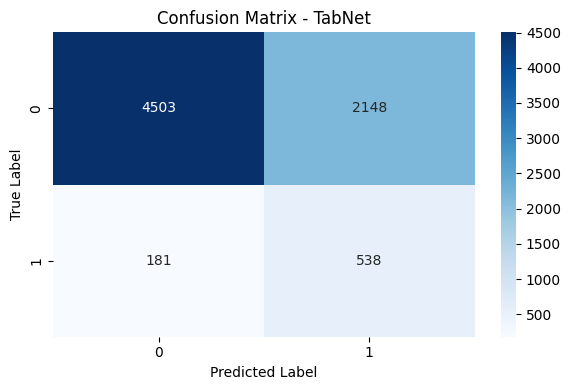

              precision    recall  f1-score   support

           0       0.96      0.68      0.79      6651
           1       0.20      0.75      0.32       719

    accuracy                           0.68      7370
   macro avg       0.58      0.71      0.56      7370
weighted avg       0.89      0.68      0.75      7370



In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión para TabNet
cm_tabnet = confusion_matrix(y_test, y_test_pred_tabnet)
report_tabnet = classification_report(y_test, y_test_pred_tabnet, output_dict=True)
report_tabnet_str = classification_report(y_test, y_test_pred_tabnet)

# Visualización de la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm_tabnet, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - TabNet")
plt.tight_layout()
plt.show()

print(report_tabnet_str)

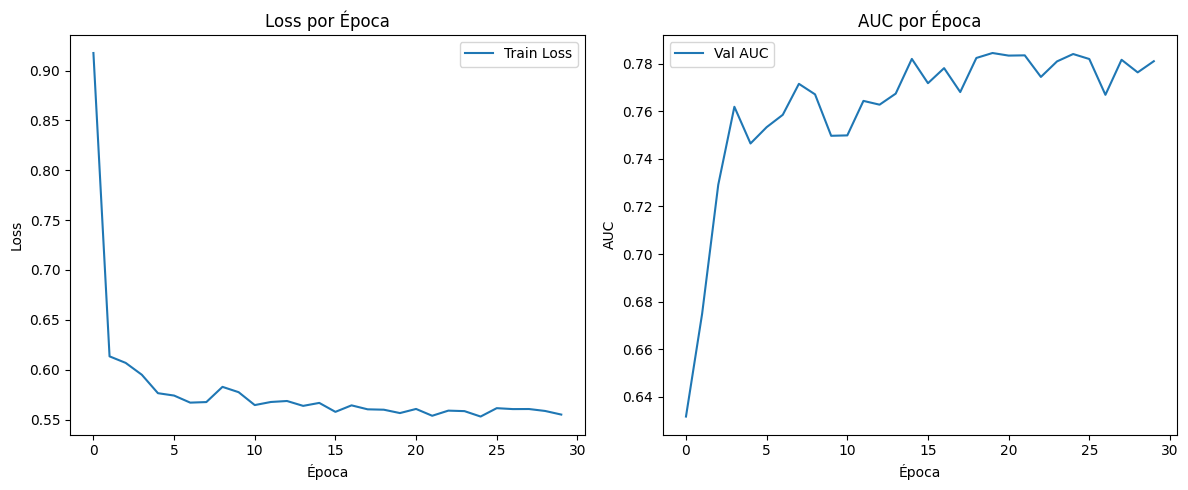

In [45]:
import matplotlib.pyplot as plt



# Curvas según las métricas disponibles
plt.figure(figsize=(12, 5))

# Loss si está disponible
if 'loss' in tabnet_best.history.history:
    plt.subplot(1, 2, 1)
    plt.plot(tabnet_best.history['loss'], label='Train Loss')
    if 'val_loss' in tabnet_best.history.history:
        plt.plot(tabnet_best.history['val_loss'], label='Val Loss')
    plt.title("Loss por Época")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()

if 'val_auc' in tabnet_best.history.history:
    plt.subplot(1, 2, 2)
    plt.plot(tabnet_best.history['val_auc'], label='Val AUC')
    plt.title("AUC por Época")
    plt.xlabel("Época")
    plt.ylabel("AUC")
    plt.legend()

plt.tight_layout()
plt.show()

In [47]:
tabnet_best.save_model("tabnet_model")


Successfully saved model at tabnet_model.zip


'tabnet_model.zip'